# Prototype Selection for Nearest Neighbor

**This is an optional assignment that will not be graded. It is an opportunity for you to gain a deeper understanding of nearest neighbor and to put your creativity to work.**

One way to speed up nearest neighbor classification is to replace the training set by a carefully chosen
subset. The selected training points can be thought of as **prototypes**.

In this notebook you will <font color="blue">*create your own strategy*</font> for selecting prototypes for nearest neighbor classification. You will apply this to the **MNIST** dataset. You will then see how your prototypes compare to a *random* subset of training points of the same size.

# 1. Setup notebook

As usual, we start by importing the required packages and data. For this notebook we will be using the **entire** `MNIST` dataset. The code below defines some helper functions that will load `MNIST` onto your computer.

In [1]:
import gzip
import sys
import os
import copy
import numpy as np
import pickle

if sys.version_info[0] == 2:
    from urllib import urlretrieve
else:
    from urllib.request import urlretrieve

In [2]:
def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    # Read the inputs in Yann LeCun's binary format.
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data / np.float32(256)

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
        #data2 = np.zeros( (len(data),10), dtype=np.float32 )
        #for i in range(len(data)):
        #    data2[i][ data[i] ] = 1.0
    return data

We now import the required packages and load in `MNIST`. If necessary, `MNIST` is downloaded onto your computer.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt 
import time
from sklearn.neighbors import BallTree

## Load the training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')

## Load the testing set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

# 2. Choosing prototypes at random

To give you a better idea of how this process works, let's first consider the case where the prototypes are chosen at random from the training set. We will set the number of prototypes to $M$.

The following function, <font color="blue">**rand_prototypes**</font>, returns an array of $M$ points chosen randomly form the training set, along with a second array containing their labels.

In [4]:
def rand_prototypes(M):
    indices = np.random.choice( len(train_labels) , M, replace=False)
    return train_data[indices,:], train_labels[indices] 

Here is an example of **rand_prototypes** in action, with $M = 1000$.

In [5]:
example_data, example_labels = rand_prototypes(1000)
print "Shape of train_data:", train_data.shape
print "Shape of array of prototypes: ", example_data.shape

Shape of train_data: (60000, 784)
Shape of array of prototypes:  (1000, 784)


Now let's check the error rate obtained on the MNIST test set (of 10,000 points) when nearest neighbor classification is performed using a set of prototypes returned by the **rand_prototypes** function. Intuitively, we would expect the error rate to go down as more prototypes are used: that is, as $M$ increases.

The function, <font color="blue">**NN_error**</font>,  computes the MNIST test error when using 1-NN classification with a specified set of prototypes (and their labels). To speed up the computation, a *ball tree* data strcutre is used.

In [6]:
def NN_error(proto_data, proto_labels):
    ball_tree = BallTree(proto_data, metric='euclidean')
    test_neighbors = np.squeeze(ball_tree.query(test_data, k=1, return_distance=False))
    test_fit = proto_labels[test_neighbors]
    return sum(test_fit != test_labels)/float(len(test_fit))

For any specific value of $M$, different random choices of the prototypes may yield different error rates. Thus, it only makes sense to talk about the **mean** error rate for a specific value of $M$. We can estimate this mean value by drawing *several* random subsets of $M$ prototypes, computing the test error with each, and then taking their average. 

The following function does this, using $k$ random sets of prototypes. It also returns a crude bound on the standard deviation of the estimated mean: the standard deviation of the $k$ error values, divided by sqrt(k).

In [7]:
def mean_error(fn_strategy, M, k=1):
    errors = np.zeros(k)
    for i in range(0,k):
        proto_data, proto_labels = fn_strategy(M)
        errors[i] = NN_error(proto_data, proto_labels) 
    return np.mean(errors), np.std(errors)/np.sqrt(k)

We now use **mean_error** to get error rates (and standard deviations) for a few different values of $M$. 

**Warning:** This will take some time, maybe half an hour or more. If you don't want to wait, choose a smaller value of $k$.

In [8]:
M_values = [1000, 2000, 3000, 4000, 5000]
errors = np.zeros(5)
errorbars = np.zeros(5)
k = 5
for i in range(0, len(errors)):
    errors[i], errorbars[i] = mean_error(rand_prototypes, M_values[i], k)

We can plot these values, along with errorbars (twice the standard deviation).

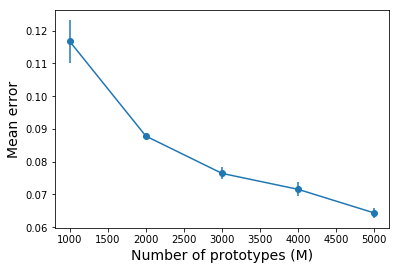

In [9]:
plt.errorbar(np.linspace(1000,5000,5), errors, yerr=errorbars*2.0, fmt='-o')
plt.xlabel('Number of prototypes (M)', fontsize=14)
plt.ylabel('Mean error', fontsize=14)
plt.show()

# 3. Design your own prototype selection algorithm

It is now time for you to suggest your own strategy for picking a set of $M$ prototypes that will be used as the basis for 1-NN classification. 

Write a function, <font color="blue">**my_prototypes**</font>, that creates a set of $M$ prototypes, using a strategy of your choosing. Like the the **rand_prototypes** function, your function should take $M$ as input and should return two arrays: the prototypes themselves, and their labels.

In [10]:
# Modify this Cell

def my_prototypes(M):
    
    # 
    # Write your own function here
    #
    
    return prototype_data, prototype_labels

# 4. Compare strategies

It's time to put your code to the test! Let's see if it can do better than selecting prototypes at random.

In [11]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual

You can use the following widget to see how your code fares against the random strategy by moving the sliders around.

In [12]:
@interact_manual( M=(100,2000,100), rounds=(1,10))
def comparison(M,rounds):
    print("Comparing your prototype selection method to random prototype selection...")
    rand_err, rand_std = mean_error(rand_prototypes, M, rounds) 
    my_err, my_std   = mean_error(  my_prototypes, M, rounds) 
    
    print;print("Number of prototypes:", M)
    print("Number of trials:", rounds)
    print("Error for random prototypes:", rand_err )
    print("Error for your prototypes:", my_err );print
    if rand_err < my_err:
        print("RANDOM prototypes win!")
    else:
        print("YOUR prototypes win!")
    

Comparing your prototype selection method to random prototype selection...

('Number of prototypes:', 1000)
('Number of trials:', 1)
('Error for random prototypes:', 0.10970000000000001)
('Error for your prototypes:', 0.13100000000000001)

RANDOM prototypes win!
